In [3]:
from pathlib import Path
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from data.img_seq_generator import ImageSequenceDataGenerator, MultiSequenceGenerator

In [4]:
AUTSL_TEST_CSV = Path(r'C:\Projects\autsl-data\test_labels_20classes.csv')
AUTSL_DEPTH_MODEL = Path(r'C:\Projects\autsl-data\rgb_depth_068.best.hdf5')
AUTSL_DEPTH_LANDMARKS_MODEL = Path(r'C:\Projects\autsl-data\multi_090.best.hdf5')

# Data
AUTSL_RGB_DATA = Path(r'C:\Projects\autsl-data\frames_rgb_20', 'test')
AUTSL_DEPTH_DATA = Path(r'C:\Projects\autsl-data\frames_depth_20', 'test')
AUTSL_LANDMARK_DATA = Path(r'C:\Projects\autsl-data\frames_landmarks_2_20', 'test')

In [5]:
autsl_df = pd.read_csv(AUTSL_TEST_CSV)
autsl_df.head()

,Unnamed: 0,Sample,ClassId,EN
0,30,signer34_sample31,86,no
1,34,signer34_sample35,13,key
2,50,signer34_sample51,120,dog
3,68,signer34_sample69,126,scissors
4,78,signer34_sample79,22,look


In [6]:
autsl_true_labels = autsl_df['EN']
autsl_classes = np.unique(autsl_true_labels)
autsl_classes

array(['apologize', 'breakfast', 'congratulations', 'dog', 'eat',
       'friend', 'garden', 'hurry', 'ill', 'key', 'look', 'money', 'no',
       'okay', 'pillow', 'room', 'scissors', 'tea', 'umbrella', 'wedding'],
      dtype=object)

In [7]:
autsl_true_label_indices = [np.where(autsl_classes == label)[0].item() for label in autsl_true_labels]
# autsl_true_label_indices
print(f"True label indice for first sample, 'no': {autsl_true_label_indices[0]}")
print(f"Class label = {autsl_classes[autsl_true_label_indices[0]]}")

True label indice for first sample, 'no': 12
Class label = no


In [8]:
# HELPERS
def make_confusion_matrix(true_labels, predictions, classes, figname):
    # Confusion Matrix
    cm = confusion_matrix(true_labels[:predictions.shape[0]], predictions)
    plt.figure(figsize=(16,10))

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='viridis')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'{figname} Confusion Matrix')
    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=360)
    plt.savefig(f"{figname}_cm.jpg", dpi=300)
    plt.show()
    
def show_image_seq(img_sequence):
    n = img_sequence.shape[0]
    fig = plt.figure(figsize=(8,8))
    r = int(n**.5)
    c = int(np.ceil(n/r))
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(img_sequence[i]/255.)
    plt.axis('off')
    plt.show()
    
def top_n_accuracy(preds, truths, n):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = truths[:preds.shape[0]]
    successes = 0
    for i in range(len(ts)):
        if ts[i] in best_n[i,:]:
            successes += 1
    return float(successes)/len(ts)

# AUTSL
## RGB + Depth Model

In [9]:
autsl_depth_model = tf.keras.models.load_model(AUTSL_DEPTH_MODEL)
autsl_depth_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB Input (InputLayer)          [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
DEPTH Input (InputLayer)        [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
EfficientNetB0_RGB (TimeDistrib (None, None, 7, 7, 1 4049571     RGB Input[0][0]                  
__________________________________________________________________________________________________
EfficientNetB0_DEPTH (TimeDistr (None, None, 7, 7, 1 4049571     DEPTH Input[0][0]                
____________________________________________________________________________________________

In [10]:
batch = 8
input_size = (224, 224, 3)
autsl_rgb_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_RGB_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_depth_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_DEPTH_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_multi_gen = MultiSequenceGenerator(autsl_df, [autsl_rgb_gen, autsl_depth_gen], shuffle=False)

In [11]:
# Gives us batch 0, X values, sequence 0, from batch 0
img_seq = autsl_rgb_gen[0][0][0]
depth_seq = autsl_depth_gen[0][0][0]

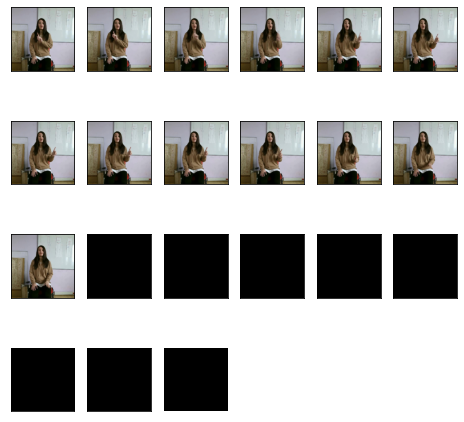

In [12]:
show_image_seq(img_seq)

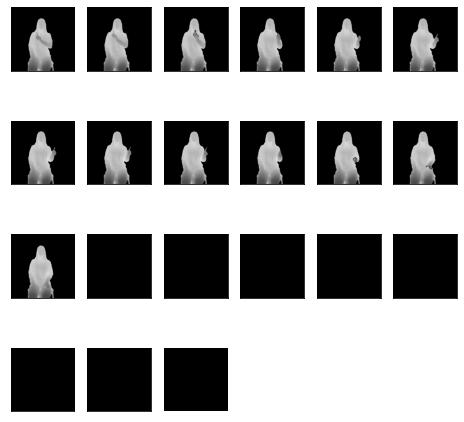

In [13]:
show_image_seq(depth_seq)

In [14]:
# Evaluate model
predictions = autsl_depth_model.predict(autsl_multi_gen, batch_size=batch, verbose=1)

41/41 [==============================] - 459s 11s/step


In [15]:
top_1_predictions = np.argmax(predictions, axis=1)
top_1_report = classification_report(autsl_true_label_indices[:top_1_predictions.shape[0]], top_1_predictions, target_names=autsl_classes)
print(top_1_report)

                 precision    recall  f1-score   support

      apologize       0.36      0.29      0.32        17
      breakfast       0.33      0.12      0.17        17
congratulations       0.11      0.14      0.12        14
            dog       1.00      0.06      0.11        17
            eat       0.15      0.29      0.20        17
         friend       0.35      0.40      0.38        15
         garden       0.52      0.88      0.65        17
          hurry       0.00      0.00      0.00        16
            ill       0.57      0.76      0.65        17
            key       0.14      0.06      0.09        16
           look       0.28      0.65      0.39        17
          money       0.00      0.00      0.00        16
             no       0.15      0.12      0.14        16
           okay       0.33      0.12      0.18        16
         pillow       0.72      0.76      0.74        17
           room       0.36      0.24      0.29        17
       scissors       0.19    

c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
top_n_accuracy(predictions, autsl_true_label_indices, 5)

0.7378048780487805

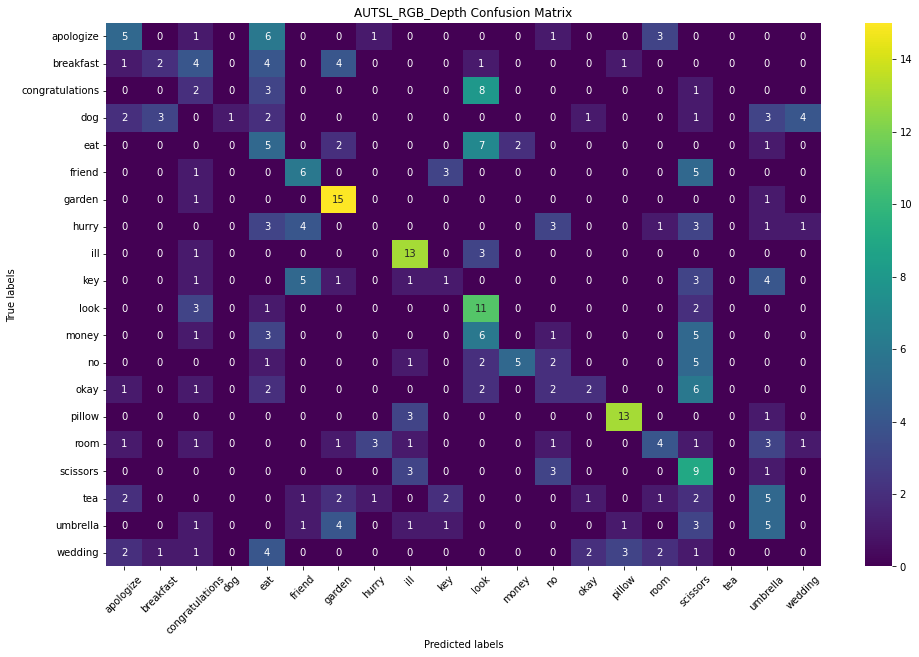

In [17]:
make_confusion_matrix(autsl_true_label_indices, top_1_predictions, autsl_classes, "AUTSL_RGB_Depth")

# AUTSL
## RGB + DEPTH + LANDMARKS

In [18]:
autsl_depth_landmarks_model = tf.keras.models.load_model(AUTSL_DEPTH_LANDMARKS_MODEL)
autsl_depth_landmarks_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rgb Input (InputLayer)          [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
depth Input (InputLayer)        [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
landmarks Input (InputLayer)    [(None, None, 224, 2 0                                            
__________________________________________________________________________________________________
EfficientNetB0_rgb (TimeDistrib (None, None, 7, 7, 1 4049571     rgb Input[0][0]                  
____________________________________________________________________________________________

In [19]:
batch = 8
input_size = (224, 224, 3)
autsl_rgb_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_RGB_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_depth_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_DEPTH_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_landmark_gen = ImageSequenceDataGenerator(autsl_df, str(AUTSL_LANDMARK_DATA), batch_size=batch, input_size=input_size, shuffle=False)
autsl_multi_gen = MultiSequenceGenerator(autsl_df, [autsl_rgb_gen, autsl_depth_gen, autsl_landmark_gen], shuffle=False)

In [20]:
# Evaluate model
predictions2 = autsl_depth_landmarks_model.predict(autsl_multi_gen, batch_size=batch, verbose=1)

41/41 [==============================] - 920s 22s/step


In [21]:
top_1_predictions2 = np.argmax(predictions2, axis=1)
top_1_report2 = classification_report(autsl_true_label_indices[:top_1_predictions2.shape[0]], top_1_predictions2, target_names=autsl_classes)
print(top_1_report2)

                 precision    recall  f1-score   support

      apologize       0.67      0.12      0.20        17
      breakfast       0.17      0.06      0.09        17
congratulations       0.12      0.14      0.13        14
            dog       0.00      0.00      0.00        17
            eat       0.17      0.41      0.25        17
         friend       0.38      0.67      0.49        15
         garden       0.56      0.82      0.67        17
          hurry       0.05      0.06      0.06        16
            ill       0.48      0.88      0.62        17
            key       0.00      0.00      0.00        16
           look       0.32      0.71      0.44        17
          money       0.11      0.12      0.11        16
             no       0.28      0.75      0.41        16
           okay       0.38      0.19      0.25        16
         pillow       0.88      0.88      0.88        17
           room       0.00      0.00      0.00        17
       scissors       0.00    

c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
top_n_accuracy(predictions2, autsl_true_label_indices, 5)

0.6676829268292683

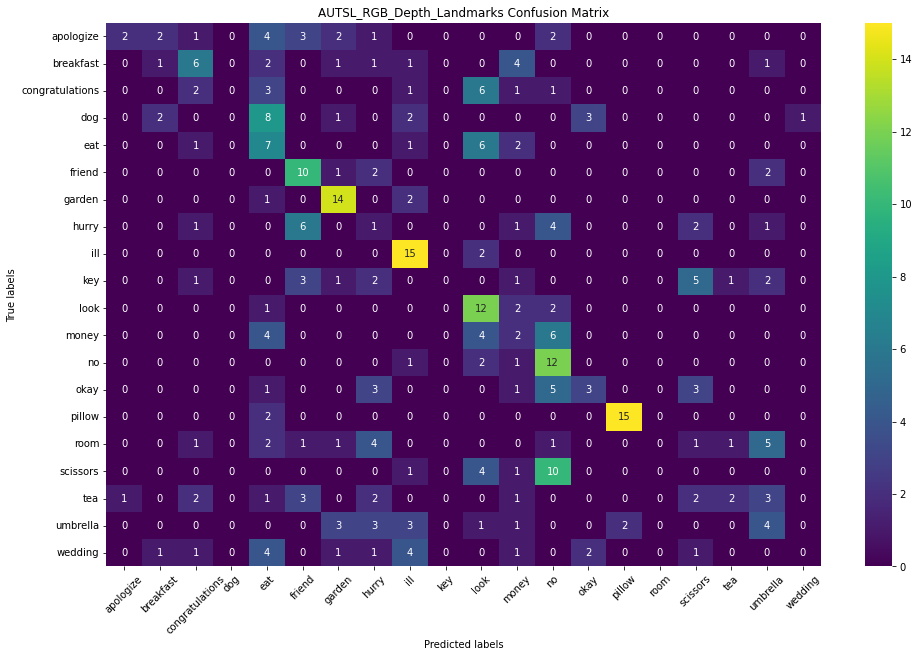

In [23]:
make_confusion_matrix(autsl_true_label_indices, top_1_predictions2, autsl_classes, "AUTSL_RGB_Depth_Landmarks")